# 实验记录
- 这里将逐步记录实验完成过程，应当可以整理成报告文件

## 实验规划
### 实验步骤划分
0. 文件功能划分
    - ```Lab5.ipynb```：实验记录
    - ```funs.py```：将学习算法的代码整理到其中
1. 数据预处理
    - 数据降维、降噪、特征提取（第11章）
    - 数据编码？貌似不需要
2. 对每个模型找到训练算法的实现，整理到```funs.py```中，并确定对应**参数**（二分类）
    - 线性回归模型（Lab1）
    - 决策树模型（Lab3）
    - 神经网络模型（调包）
    - 支持向量机（Lab2）
    - XGBoost模型（Lab3）
3. 基于二分类器搭建多分类器框架，如有必要可以整合到```funs.py```中
    - 由于数据集的类别数较少，采取 **一对一** 或者 **一对多** 的思路
4. 对每个模型都做一遍**调参**流程，选取最优的结果
    - 划分训练集和验证集
    - 设定参数进行训练
    - 根据训练好的模型进行验证，获得验证指标（需要统一）
    - 调整参数，重复测试（十折交叉验证）
    - 保存模型
5. 根据最好的模型做预测，保存结果


### 完成步骤
1. 数据预处理：参考11章，核心内容为降维和降噪
2. 基于二分类器搭建多分类器框架，暂定**一对一**思路
    - 问题分解（第3章）
    - 分类器集成
    - 评价体系
3. 二分类训练算法的实现（有许多地方需要整合，例如fit方法、评分计算score方法等，可以适当延后）
    - 选择可以直接调包的**神经网络模型**完成从训练、调参到评估的完整流程，然后套用到其他模型
4. 对单个模型的流程
    - 数据预处理
    - 多分类器框架
    - 调参，获得最优模型
        - 设定分类器评价体系
        - 对于不同超参数，用**十折交叉验证**的方式获得相应评分
        - 用**网格法**确定最优超参数
        - 用最优超参数重新对**全体数据**进行训练，得到**最优模型**
    - 保存最优模型
5. 对所有模型类型的流程
    - 对每种模型的最优超参数，确定其评分，根据评分及耗时等方面综合考虑最优类型
    - 直接选取最优类型对应的最优模型
    - 根据最优模型进行预测，保存结果

注：有必要重新学习特征预处理、模型评估、调参、模型选择、假设检验等一整套完备流程，再进行实验

学习途径主要为：课件和课本，网络社区，往期优秀作业

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from skrebate import ReliefF
from sklearn.feature_selection import RFE

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier #调包
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression as LR #调包
from sklearn.svm import SVC

import xgboost as xgb
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from skrebate import ReliefF

from funs import *

## Data Process
- 数据读取
- 去噪（有大量outliers，必须进行）（将离群值设置为```nan```，交由第四步补全数据）
- 标准化（注意outliers，不能直接归一）
    - 均值归零，方差归一
- 处理缺失数据
    - 平均值填补
    - KNN方法填补，参考 https://zhuanlan.zhihu.com/p/270551105
    - 删除不完整数据
- 降维
    - 特征选择：Relief-F（11章）

### 数据读取
- 可以看出，每个特征中都包含少量outliers以及缺失值，且分布较为分散
- 除去极为明显的outliers后，大部分特征是连续型的，近似为正态分布或者均匀分布；还有部分特征可能是离散型的（取值较少）；整体分布正常，无需多做处理

In [2]:
# 数据读取
X_df = pd.read_csv('Dataset/train_feature.csv')
y_df = pd.read_csv('Dataset/train_label.csv')

X_pred_df = pd.read_csv('Dataset/test_feature.csv')
#X_pred_df.isnull().sum()
#X_df.isnull().sum()

In [37]:
# 查看标签类别数
c = y_df['label'].unique().__len__() #分类数
y_df.label.value_counts(dropna=False)

0    2523
1    2521
2    2500
3    2456
Name: label, dtype: int64

In [4]:
# 查看指定特征分布
X_df[X_df.columns].describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119
count,9960.000000,9946.000000,9955.000000,9952.000000,9954.000000,9.955000e+03,9956.000000,9956.000000,9935.000000,9954.000000,...,9951.000000,9942.000000,9949.000000,9953.000000,9971.000000,9954.000000,9966.000000,9945.000000,9961.000000,9955.000000
mean,1381.896486,58.715384,11.157463,215.609224,104.244826,5.159948e+03,1418.185014,193.551326,49.467136,228.066855,...,116.686062,27.416274,1535.670218,15.054217,148.445119,59.534157,1492.845976,26.923894,53.122879,1608.872828
std,20342.092034,3067.018960,213.548216,3254.119426,1809.139214,8.325174e+04,21803.434424,3078.353897,1062.106891,4636.090534,...,1933.557182,562.969699,22002.428225,226.915755,3492.678496,1054.340669,22568.166582,570.147079,1009.911312,23191.540756
min,26.000000,-72400.900016,0.000004,3.000000,0.000000,0.000000e+00,27.000000,3.000000,1.000000,0.042353,...,0.000000,0.000128,27.000000,0.000122,0.051135,0.000000,24.000000,0.000010,0.000000,26.000000
25%,45.000000,-5.442525,0.248601,7.000000,3.000000,1.620000e+02,45.000000,7.000000,1.000000,1.390866,...,3.000000,0.289902,45.000000,0.255261,1.384008,1.000000,45.000000,0.294560,1.000000,45.000000
50%,50.000000,-0.060218,0.504924,8.000000,4.000000,1.940000e+02,50.000000,8.000000,2.000000,2.730417,...,4.000000,0.708386,50.000000,0.511428,2.789308,2.000000,50.000000,0.702308,2.000000,50.000000
75%,55.000000,5.482893,0.751965,8.000000,5.000000,2.220000e+02,55.000000,8.000000,4.000000,5.413222,...,5.000000,1.440402,55.000000,0.760929,5.354379,3.000000,54.000000,1.399526,3.000000,55.000000
max,526876.000000,105832.015208,8448.902842,79794.000000,57936.000000,2.072000e+06,505945.000000,81060.000000,47816.000000,210388.669161,...,66493.000000,29581.611161,514420.000000,6983.682765,195804.282475,49235.000000,632196.000000,23978.517876,40870.000000,564200.000000


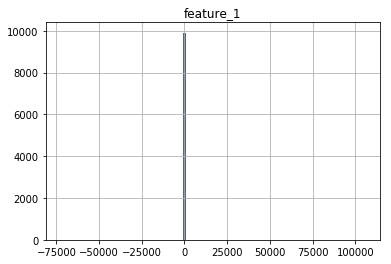

In [5]:
X_df.hist('feature_1',bins=100)
plt.show()

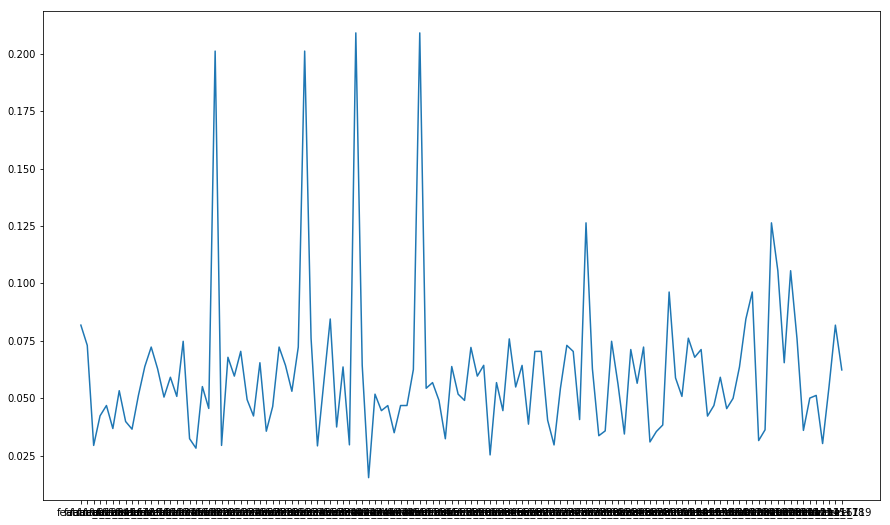

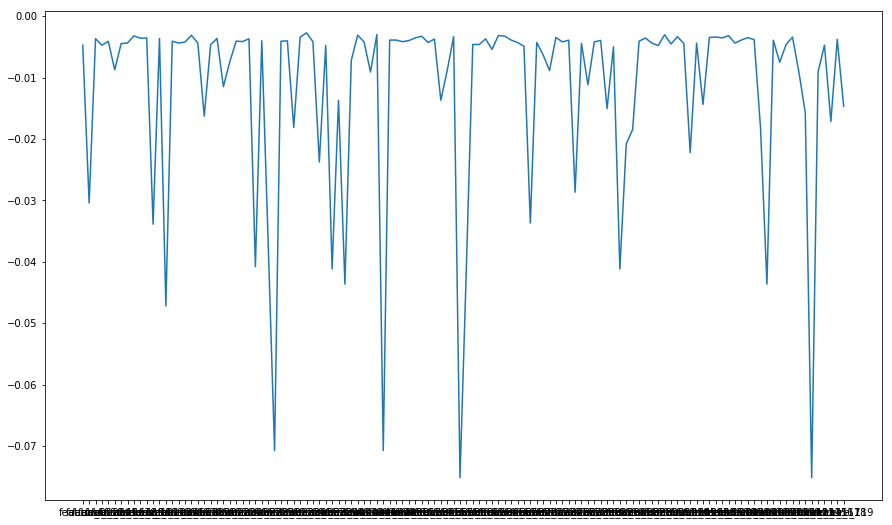

In [7]:
# 数据相关性，可以看出特征之间没有明显的相关性
plt.figure(figsize=(15,9))
plt.plot((X_df.corr()-np.identity(120)).max())
plt.show()
plt.figure(figsize=(15,9))
plt.plot((X_df.corr()-np.identity(120)).min())
plt.show()

### 去噪

In [3]:
# 去噪：经过观察，离群值过于离谱，应该重做。将各个属性的outliers值设置为nan
for feature in X_df.columns:
    Q1 = X_df[feature].quantile(0.1)
    Q3 = X_df[feature].quantile(0.9)
    IQR = Q3 - Q1
    X_df.loc[X_df[(X_df[feature]<Q1-1.5*IQR)|(X_df[feature]>Q3+1.5*IQR)].index,[feature]]=np.nan

    X_pred_df.loc[X_pred_df[(X_pred_df[feature]<Q1-1.5*IQR)|(X_pred_df[feature]>Q3+1.5*IQR)].index,[feature]]=np.nan

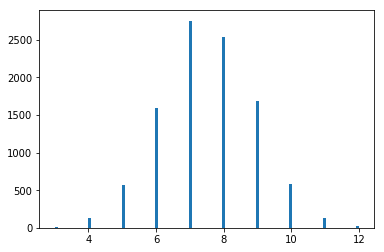

In [6]:
# 去噪后特征的取值分布
col = X_df.feature_3
n_bins=max(col.values)-min(col.values)
plt.hist(col.values, 100, range=[min(col.values),max(col.values)])
plt.show()

### 标准化

In [4]:
# 标准化
# sklearn.preprocessing.robust_scale(X, *, axis=0, with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0), copy=True, unit_variance=False)
from sklearn.preprocessing import StandardScaler

standardScaler = StandardScaler() 
standardScaler.fit(X_df)

X = standardScaler.transform(X_df)
X_pred = standardScaler.transform(X_pred_df)
y = y_df.values

X_df = pd.DataFrame(X, columns=X_df.columns)
X_pred_df = pd.DataFrame(X_pred, columns=X_pred_df.columns)

### 处理缺失数据

In [40]:
# 处理缺失数据：填补（KNN方法，注意要先标准化）
# 可能是冗余特征的干扰，效果不好
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5,weights='uniform', metric='nan_euclidean')   # 需要归一化（？）
X = imputer.fit_transform(X)
X_pred = imputer.transform(X_pred)                                              # 对预测目标进行填补

X_df = pd.DataFrame(X, columns=X_df.columns)
X_pred_df = pd.DataFrame(X_pred, columns=X_pred_df.columns)
X, y = X_df.values, y_df.values

In [5]:
# 处理缺失数据：填补（平均值法）
for feature in X_df.columns:
    mean = X_df[feature].mean()
    # max(set(X_df[feature]),key=X_df[feature].count)
    X_df.loc[X_df[np.isnan(X_df[feature])].index,feature] = mean
X, y = X_df.values, y_df.values

In [5]:
# 处理缺失数据：填补（平均值、中位数、众数）
def myfill(X, discrete_threshold=10):
    for col in X.columns:
        #判断第一个数是不是整数
        if len(X[col].value_counts())>discrete_threshold:
            X[col] = X[col].fillna(X[col].mean())
        else:
            X[col] = X[col].fillna(float(X[col].mode()))
    return X

X_df = myfill(X_df, 10)
X_pred_df = myfill(X_pred_df, 10)
X, y = X_df.values, y_df.values
X_pred = X_pred_df.values

In [6]:
# 处理缺失数据：过滤（只使用完整数据，丢弃不完整数据）
tmp = pd.concat([X_df,y_df],axis=1)
tmp = tmp.dropna()#.values
y_df = tmp['label']
X_df = tmp.drop(columns=['label'])

X, y = X_df.values, y_df.values

### 可选择保存结果并查看

In [8]:
# 保存结果
X_df.to_csv('Dataset/train_f_preprocessed_mean.csv',sep=',',header=True, index=False)
y_df.to_csv('Dataset/train_l_preprocessed_mean.csv',sep=',',header=True, index=False)

In [9]:
# check
print(X_df['feature_0'][168:175])

168    230029.0
169        41.0
170    113082.0
171        43.0
172        51.0
173        50.0
174        54.0
Name: feature_0, dtype: float64


In [6]:
# 退标准化，用于查看预处理结果。正式测试时不做
X = standardScaler.inverse_transform(X)
X_pred = standardScaler.inverse_transform(X_pred)
X_df =  pd.DataFrame(X, columns=X_df.columns)
X_pred_df =  pd.DataFrame(X_pred, columns=X_pred_df.columns)
X_df[:5]

### 特征选择

In [7]:
# 降维：Relief-F 特征选择，注意在后面要在训练前transform()
X_scaled=X_df.values
#X_scaled[X_scaled.columns] -= X_scaled[X_scaled.columns].min()
#X_scaled[X_scaled.columns] /= X_scaled[X_scaled.columns].max()
#X_scaled = X_scaled.values

r = ReliefF(discrete_threshold=10, n_neighbors=10, n_jobs=-1)
r.set_params(n_features_to_select=20)   # 选取重要性权重最大的20项特征
r.fit(X_scaled, y)

ReliefF(n_features_to_select=20, n_jobs=-1, n_neighbors=10)

In [9]:
# 查看最大的若干权重，表面上看结果差距不大
print(np.sort(r.feature_importances_)[-20:])

[0.00176875 0.00177547 0.00179162 0.00187916 0.00190851 0.00196221
 0.00212333 0.00213682 0.00219273 0.00247154 0.00263432 0.00267333
 0.00301523 0.00316137 0.00321262 0.00345905 0.00377955 0.004083
 0.00436899 0.00479645]


In [33]:
# 输出权重
pd.DataFrame(r.feature_importances_).to_csv("Dataset/feature_importance.csv")

### 拆分训练集和验证集
- 演示 train_test_split
- 也可以不在此拆分，直接做交叉验证

In [12]:
# 拆分训练集和验证集
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_df.values, y_df.values, test_size=0.2)#, random_state=0

In [35]:
# 以全集来训练检测
X_train, y_train = np.array(X_df.values), np.array(y_df.values)
X_test, y_test = np.array(X_df.values), np.array(y_df.values)

In [14]:
len(X_train), len(y_test)

(8000, 2000)

## Classifiers

### 神经网络

In [26]:
# 模型+训练
model_MLP = MLPClassifier(hidden_layer_sizes=[30],early_stopping=False, max_iter=2000,learning_rate_init=1e-3,tol=1e-4,alpha=1e-5,activation='logistic')#,solver="sgd",learning_rate="adaptive"
model_MLP.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=[30],
              max_iter=2000)

In [15]:
# 特征选择-交叉验证
model_MLP = MLPClassifier(hidden_layer_sizes=[30],max_iter=2000, early_stopping=False, learning_rate_init=1e-3,tol=1e-4,alpha=1e-6,activation='logistic')#,solver="sgd",learning_rate="adaptive"

for n_feature in range(5, 31, 5):
    r.set_params(n_features_to_select=n_feature)
    X_cutted = r.transform(X)
    result = cross_val_score(model_MLP, X_cutted, y, cv=5)
    print("number of features: ", n_feature, '\t', "平均准确率: ", np.mean(result), '\t',
        "准确率标准差: ", np.std(result))

number of features:  5 	 平均准确率:  0.25329999999999997 	 准确率标准差:  0.007433707016018327
number of features:  10 	 平均准确率:  0.2644 	 准确率标准差:  0.00966126285741156
number of features:  15 	 平均准确率:  0.2596 	 准确率标准差:  0.011056219968868214
number of features:  20 	 平均准确率:  0.2569 	 准确率标准差:  0.005285830114561009
number of features:  25 	 平均准确率:  0.25739999999999996 	 准确率标准差:  0.01005186549850326
number of features:  30 	 平均准确率:  0.25160000000000005 	 准确率标准差:  0.011257886124846007


In [17]:
for n_feature in range(5, 15, 1):
    r.set_params(n_features_to_select=n_feature)
    X_cutted = r.transform(X)
    result = cross_val_score(model_MLP, X_cutted, y, cv=5)
    print("number of features: ", n_feature, '\t', "平均准确率: ", np.mean(result), '\t',
        "准确率标准差: ", np.std(result))

number of features:  5 	 平均准确率:  0.2589 	 准确率标准差:  0.009041017641836574
number of features:  6 	 平均准确率:  0.2519 	 准确率标准差:  0.006445153217728813
number of features:  7 	 平均准确率:  0.25670000000000004 	 准确率标准差:  0.007865112840894282
number of features:  8 	 平均准确率:  0.2545 	 准确率标准差:  0.006033241251599348
number of features:  9 	 平均准确率:  0.2611 	 准确率标准差:  0.009350935782048776
number of features:  10 	 平均准确率:  0.2552 	 准确率标准差:  0.009146584061823308
number of features:  11 	 平均准确率:  0.25730000000000003 	 准确率标准差:  0.004802082881417192
number of features:  12 	 平均准确率:  0.2591 	 准确率标准差:  0.00631981012372999
number of features:  13 	 平均准确率:  0.255 	 准确率标准差:  0.006066300355241246
number of features:  14 	 平均准确率:  0.25880000000000003 	 准确率标准差:  0.00646993044784873


In [37]:
# 调参
best_acc = 0
best_para = [0,0,0]
r.set_params(n_features_to_select=15)#保险起见，选取15个特征进行训练
X_train_c, X_test_c = r.transform(X_train), r.transform(X_test)
for lr_init in [1e-2, 1e-3, 1e-4, 1e-5]:
    for tol in [1e-2, 1e-4, 1e-6]:
        for alpha in [1e-1, 1e-3, 1e-5]:
            model_MLP = MLPClassifier(hidden_layer_sizes=[10],max_iter=200,
                learning_rate_init=lr_init, tol=tol, alpha=alpha, activation='logistic')
            model_MLP.fit(X_train_c, y_train)
            acc = model_MLP.score(X_test_c, y_test)
            if acc>best_acc:
                best_acc = acc
                best_para = [lr_init, tol, alpha]
print("best accuracy:", best_acc, '\n', "init lr:", best_para[0], "tol:", best_para[1], "alpha:", best_para[2])

C:\Users\高高\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\高高\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\高高\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\高高\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and th

best accuracy: 0.261 
 init lr: 1e-05 tol: 0.0001 alpha: 0.1


C:\Users\高高\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [38]:
# 双隐藏层测试
best_acc = 0
best_para = [0,0,0]
r.set_params(n_features_to_select=15)#保险起见，选取15个特征进行训练
X_train_c, X_test_c = r.transform(X_train), r.transform(X_test)
for lr_init in [1e-2, 1e-3, 1e-4, 1e-5]:
    for tol in [1e-2, 1e-4, 1e-6]:
        for alpha in [1e-1, 1e-3, 1e-5]:
            model_MLP = MLPClassifier(hidden_layer_sizes=[5, 5],max_iter=200,
                learning_rate_init=lr_init, tol=tol, alpha=alpha, activation='logistic')
            model_MLP.fit(X_train_c, y_train)
            acc = model_MLP.score(X_test_c, y_test)
            if acc>best_acc:
                best_acc = acc
                best_para = [lr_init, tol, alpha]
print("best accuracy:", best_acc, '\n', "init lr:", best_para[0], "tol:", best_para[1], "alpha:", best_para[2])

C:\Users\高高\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\高高\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\高高\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\高高\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and th

best accuracy: 0.264 
 init lr: 0.01 tol: 1e-06 alpha: 1e-05


C:\Users\高高\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [23]:
def train_mlp(X_train, y_train, X_test, y_test, hidden_layer, lr, alpha, tol, activation, random=52):
    model_MLP = MLPClassifier(hidden_layer, activation, alpha=alpha, learning_rate_init=lr, tol=tol, random_state=random)
    model_MLP.fit(X_train, y_train)
    acc = model_MLP.score(X_test, y_test)
    return acc

### logistic回归
- 二分类拓展到多分类

In [29]:
# 降维：特征选择-交叉验证

OvO = OneVsOneClassifier(LR(penalty='l2',tol=1e-5)) #调包, solver= 'liblinear',fit_intercept=True,max_iter=1000, C=1.
#OvO = OneVsOneClassifier(LogisticRegression(tol=1e-5,fit_intercept=False)) #自己实现
for n_feature in range(1, 20, 1):
    r.set_params(n_features_to_select=n_feature)
    X_cutted = r.transform(X)
    print("number of features: ", n_feature, '\t', "accuarcy:", np.mean(cross_val_score(OvO, X_cutted, y, cv=10)))#cv=5


number of features:  1 	 accuarcy: 0.24910000000000002
number of features:  2 	 accuarcy: 0.2486
number of features:  3 	 accuarcy: 0.2536
number of features:  4 	 accuarcy: 0.25050000000000006
number of features:  5 	 accuarcy: 0.2574
number of features:  6 	 accuarcy: 0.25650000000000006
number of features:  7 	 accuarcy: 0.25730000000000003
number of features:  8 	 accuarcy: 0.2563000000000001
number of features:  9 	 accuarcy: 0.2608
number of features:  10 	 accuarcy: 0.2616
number of features:  11 	 accuarcy: 0.2657
number of features:  12 	 accuarcy: 0.2617
number of features:  13 	 accuarcy: 0.2591
number of features:  14 	 accuarcy: 0.26080000000000003
number of features:  15 	 accuarcy: 0.2581
number of features:  16 	 accuarcy: 0.2599
number of features:  17 	 accuarcy: 0.2605
number of features:  18 	 accuarcy: 0.2592
number of features:  19 	 accuarcy: 0.2563


In [62]:
# 调参
best_acc = 0
best_para = []
r.set_params(n_features_to_select=20)#似乎多一些特征效果更好
X_train_c, X_test_c = r.transform(X_train), r.transform(X_test)
for penalty in ['l1', 'l2']:
    for tol in [1e-1, 1e-2, 1e-3, 1e-4]:
        for C in [10, 1, 1e-1]:
            OvO = OneVsOneClassifier(LR(penalty,tol=tol,C=C,fit_intercept=False,solver='liblinear'))
            OvO.fit(X_train_c, y_train)
            acc = OvO.score(X_test_c, y_test)
            if acc>best_acc:
                best_acc = acc
                best_para = [penalty, tol, C]
print("best accuracy:", best_acc, '\n', "penalty", best_para[0], "tol:", best_para[1], "C:", best_para[2])

best accuracy: 0.2535 
 penalty l1 tol: 0.1 C: 1


### XGBoost

In [63]:
def train_XGB(X_train, y_train, X_test, y_test, lr=0.1, max_depth=5, colsample_bytree=0.8, subsample=0.8):
    clf = xgb.XGBClassifier(learning_rate=lr, max_depth=max_depth, colsample_bytree=colsample_bytree, subsample=subsample)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = np.mean(y_pred == y_test)
    return acc

In [65]:
r.set_params(n_features_to_select=15)#
X_train_c, X_test_c = r.transform(X_train), r.transform(X_test)
for lr in [0.01, 0.05, 0.1, 0.5, 1]:
    for max_depth in [2, 3, 4]:
        for colsample_bytree in [0.6, 0.8, 1]:
            for subsample in [0.6, 0.8, 1]:
                acc = train_XGB(X_train_c, y_train, X_test_c, y_test, lr, max_depth, colsample_bytree, subsample)
                if acc > best_acc:
                    best_acc = acc
                    best_info = (lr, max_depth, colsample_bytree, subsample)
print("best_acc:", best_acc, '\n', "learning_rate:", best_info[0], "max_depth:", best_info[1], "colsample_bytree:", best_info[2], "subsample:", best_info[3])

best_acc: 0.2675 
 learning_rate: 1 max_depth: 4 colsample_bytree: 1 subsample: 0.8


### 决策树（分类）

In [81]:
best_acc = 0
best_para = [0,0,0]
r.set_params(n_features_to_select=50)
X_c = r.transform(X)
for criterion in ['entropy', 'gini']:
    for max_depth in [7,5,3,1]:
        for ccp_alpha in [1, 2e-1, 1e-1, 1e-2]:
            model_DTC = DecisionTreeClassifier(criterion= criterion, max_depth=max_depth, min_samples_leaf=10, ccp_alpha=ccp_alpha)
            #model_DTC.fit(X_train_c, y_train)
            acc = np.mean(cross_val_score(model_DTC, X_c, y, cv=5))
            if acc>best_acc:
                best_acc = acc
                best_para = [criterion, max_depth, ccp_alpha]
print("best accuracy:", best_acc, '\n', "criterion:", best_para[0], "max_depth:", best_para[1], "ccp_alpha:", best_para[2])

best accuracy: 0.2523 
 criterion: entropy max_depth: 7 ccp_alpha: 1


### 随机森林
- 额外尝试

In [ ]:
model_RFC = RandomForestClassifier(n_estimators=100, criterion = "entropy", max_depth=3, max_features='auto') #调包
#OvO = OneVsOneClassifier(LogisticRegression(tol=1e-5,fit_intercept=True))
for n_feature in range(10, 121, 10):
    #r.set_params(n_features_to_select=n_feature)
    #X_train = r.transform(X)
    print(np.mean(cross_val_score(model_RFC, X_train, y_train)))#cv=5

### 支持向量机

In [28]:
class SVM:
    '''
    支持向量机模型（二分类）,采用SGD或者SMO算法求解\n
    建议调用SGD，因为从之前的测试来看该算法更优
    '''
    def __init__(self, lr=1e-4, tol=1e-4, C=10, max_iter=10):
        """
        lr:学习率
        tol:当步长小于该值，训练停止
        C:正则项的倒数，C越小，KKT条件判断越严格
        max_iter:
        """
        #self.dim = dim
        self.lr = lr
        self.tol = tol
        self.C = C
        self.max_iter = max_iter

    def fit(self, X, y):
        """
        Fit the coefficients via SGD (mini-batch) method
        """
        self.dim = X.shape[1]
        
        w = np.zeros((1, self.dim))
        b = 0
        #cost = []

        start = t.time()
        for j in range(self.max_iter):
            arr=np.array([i for i in range(X.shape[0])])
            np.random.shuffle(arr)
            for i in arr:
                if y[i] * (X[i].dot(w.T)) >= 1:
                    gradient = 0
                    grad_b = 0
                else :
                    gradient = -y[i] * X[i]
                    grad_b = -y[i]
                gradient = w + (self.C * gradient)
                grad_b = self.C * grad_b
                w = w - self.lr * gradient
                b = b - self.lr * grad_b
                #cost.append(self.cost(X, y, w, b))

            if np.linalg.norm(self.lr * gradient) < self.tol:
                break
     
        self.w = w
        self.b = b

        end = t.time()
        self.train_time = end - start
        return #cost

    def predict(self, X):
        """
        Use the trained model to generate prediction on a
        collection of data points.\n
        X is n*dim 's array
        """
        y_hat = np.dot(X, self.w.T) + self.b
        y_hat[y_hat>=0] = 1.0#
        y_hat[y_hat<-0] = 0.0#
        return y_hat

    def predict_proba(self, X):
        """
        Use the trained model to generate prediction probabilities on a
        collection of data points.\n
        X is n*dim 's array
        """
        y_hat = np.dot(X, self.w.T) + self.b
        y_hat = np.array(self.sigmoid(y_hat)).reshape(len(y_hat))
        return y_hat
    

    def score(self, X, y):
        """
        accuracy score
        """
        y_hat = self.predict(X)
        miss = y-y_hat
        return 1 - miss.T@miss / len(y)

    def sigmoid(self, x):
        """The logistic sigmoid function"""
        return 1.0/(1 + np.exp(-x))# self.w_hat

    def cost_func(self, X, y, w, b):
        """The cost function"""
        result = 0
        for i in range(X.shape[0]):
             y_pre = X[i].dot(w.T) + b
             if y[i] * y_pre >= 1 :
                 continue
             else :
                 result = result + (1 - y[i] * y_pre)
        result = result / X.shape[0]
        result = self.C * result + (np.linalg.norm(w) ** 2) / 2

        return result
    
    def get_params(self, deep=False):
        '''获取模型参数'''
        dic = dict()
        dic['lr'] = self.lr
        dic['tol'] = self.tol
        dic['max_iter'] = self.max_iter
        dic['C'] = self.C
        if deep:
            pass
        return dic

In [33]:
# 调试参数-交叉验证
best_acc = 0
best_para = [0,0,0]
r.set_params(n_features_to_select=12)#选取15个特征进行训练
X_c = r.transform(X)
for kernel in ['linear', 'rbf']:
    for tol in [1e-3, 1e-2, 1e-1]:
        for C in [1, 0.5, 0.1, 3]:
            #model_SVM = OneVsOneClassifier(SVM(lr, tol, C))
            model_SVM = OneVsOneClassifier(SVC(tol=tol, C=C, kernel=kernel, max_iter=200))
            acc = np.mean(cross_val_score(model_SVM, X_c, y, cv=5))
            if acc>best_acc:
                best_acc = acc
                best_para = [kernel, tol, C]
print("best accuracy:", best_acc, '\n', "kernel:", best_para[0], "tol:", best_para[1], "C:", best_para[2])

C:\Users\高高\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\高高\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\高高\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\高高\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

best accuracy: 0.2524 
 kernel: linear tol: 0.001 C: 0.5


## 假设验证


## 预测

In [8]:
# 预处理
X_pred_df = myfill(X_pred_df, 10)
X_pred = X_pred_df.values

In [9]:
r.set_params(n_features_to_select=15)
X_ = r.transform(X)
X_pred_ = r.transform(X_pred)

In [10]:
clf = xgb.XGBClassifier(learning_rate=1, max_depth=4, colsample_bytree=1, subsample=0.8)
clf.fit(X_, y)
y_pred = clf.predict(X_pred_)

In [12]:
y_pred_df = pd.DataFrame(y_pred, columns=['label'])
y_pred_df.to_csv('Dataset/test_label.csv', index=False)

## 日志
* 1.15 完成预处理前面部分。接下来完善多分类Relief-F的代码并完成特征选择部分，进入正式训练环节
* 1.16 找到较可靠的Relief-F实现。接下来解决部分数据unhashable的问题，进行初步特征选择，用神经网络模型进行交叉验证
* 1.17 搭建好交叉验证的实现，神经网络模型、随机森林模型、二分类逻辑回归模型准备就绪。接下来着手完成 特征选择+神经网络模型+交叉验证的pipeline 并获取实验结果；二分类->多分类 模型构建；尝试将特征划分为离散型和连续型，分别进行处理（感觉比较困难）
* 1.18 pipeline搭建流程已熟悉，得到了若干结果，对lab1的结果重新检验了一遍。接下来完成其他模型，等待数据预处理的新进展，开始写实验报告
* 1.19 尝试了一些新模型：回归树模型，实验报告原理部分基本完成。接下来全力完成实验报告；完善本文件；尝试引入同学推荐的weighted accuracy指标，改善准确率不能突破的困境
* 1.20 时间紧张来不及做假设检验，其他任务勉强完成，提交实验报告